# Utilities
----------------

This example shows various useful utilities that can be used to improve atom's pipelines.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from sklearn.metrics import fbeta_score
from atom import ATOMClassifier, ATOMLoader

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,MelbourneAirport,18.0,26.9,21.4,7.0,8.9,SSE,41.0,W,SSE,...,95.0,54.0,1019.5,1017.0,8.0,5.0,18.5,26.0,Yes,0
1,Adelaide,17.2,23.4,0.0,NaN,NaN,S,41.0,S,WSW,...,59.0,36.0,1015.7,1015.7,NaN,NaN,17.7,21.9,No,0
2,Cairns,18.6,24.6,7.4,3.0,6.1,SSE,54.0,SSE,SE,...,78.0,57.0,1018.7,1016.6,3.0,3.0,20.8,24.1,Yes,0
3,Portland,13.6,16.8,4.2,1.2,0.0,ESE,39.0,ESE,ESE,...,76.0,74.0,1021.4,1020.5,7.0,8.0,15.6,16.0,Yes,1
4,Walpole,16.4,19.9,0.0,NaN,NaN,SE,44.0,SE,SE,...,78.0,70.0,1019.4,1018.9,NaN,NaN,17.4,18.1,No,0


## Use the utility attributes

In [3]:
atom = ATOMClassifier(X, random_state=1)
atom.clean()

# Quickly check what columns have missing values
print(f"Columns with missing values:\n{atom.nans}")

# Or what columns are categorical
print(f"\nCategorical columns: {atom.categorical}")

# Or if the dataset is scaled
print(f"\nIs the dataset scaled? {atom.scaled}")

Columns with missing values:
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
dtype: int64

Categorical columns: Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'], dtype='object')

Is the dataset scaled? False


## Use the stats method to assess changes in the dataset

In [4]:
# Note the number of missing values and categorical columns
atom.stats()

Dataset stats ==================== >>
Shape: (142193, 22)
Memory: 61.69 MB
Scaled: False
Missing values: 316559 (10.1%)
Categorical features: 5 (23.8%)
Duplicate samples: 45 (0.0%)
-------------------------------------
Train set size: 113755
Test set size: 28438
-------------------------------------
|   |   dataset |     train |      test |
| - | --------- | --------- | --------- |
| 0 |   0 (0.0) |   0 (0.0) |   0 (0.0) |
| 1 |   0 (0.0) |   0 (0.0) |   0 (0.0) |


In [5]:
# Now, let's impute and encode the dataset...
atom.impute()
atom.encode()

# ... and the values are gone
atom.stats()

Dataset stats ==================== >>
Shape: (56420, 22)
Memory: 9.93 MB
Scaled: False
Outlier values: 3210 (0.3%)
-------------------------------------
Train set size: 45039
Test set size: 11381
-------------------------------------
|   |   dataset |     train |      test |
| - | --------- | --------- | --------- |
| 0 |   0 (0.0) |   0 (0.0) |   0 (0.0) |
| 1 |   0 (0.0) |   0 (0.0) |   0 (0.0) |


## Inspect feature distributions

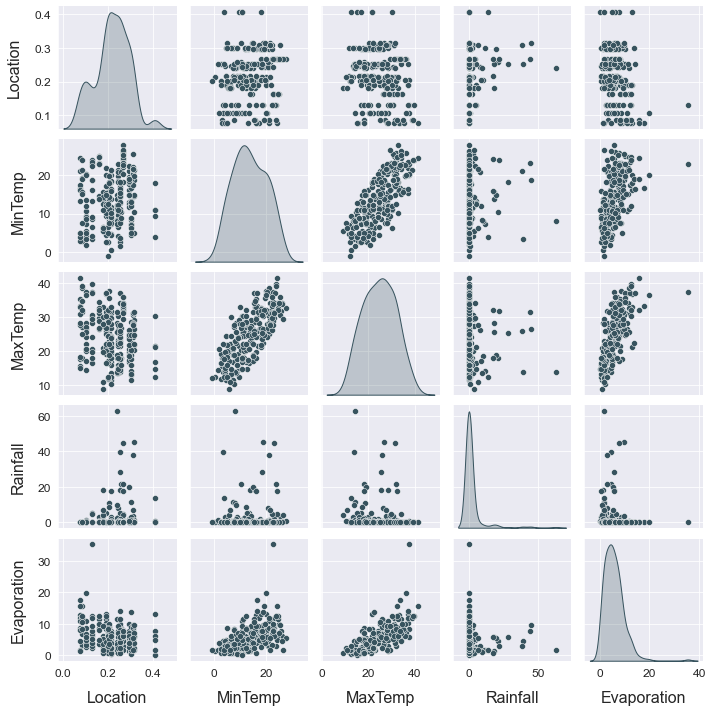

In [6]:
# Compare the relationship of multiple columns with a scatter maxtrix
atom.plot_scatter_matrix(columns=slice(0, 5))

In [7]:
# Check which distribution fits a column best
atom.distribution(columns="Rainfall")

Rainfall
dist        stat            
beta        score     0.6506
            p_value      0.0
expon       score     0.6506
            p_value      0.0
gamma       score     0.6465
            p_value      0.0
invgauss    score     0.4717
            p_value      0.0
lognorm     score     0.6485
            p_value      0.0
norm        score     0.3807
            p_value      0.0
pearson3    score     0.6506
            p_value      0.0
triang      score     0.7191
            p_value      0.0
uniform     score     0.8914
            p_value      0.0
weibull_min score     0.6506
            p_value      0.0
weibull_max score     0.8896
            p_value      0.0

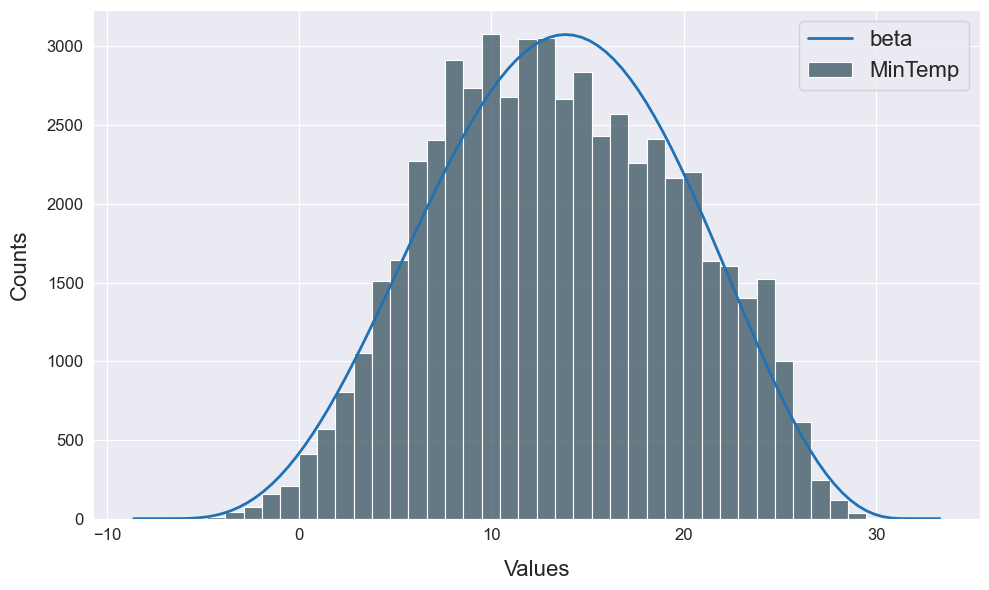

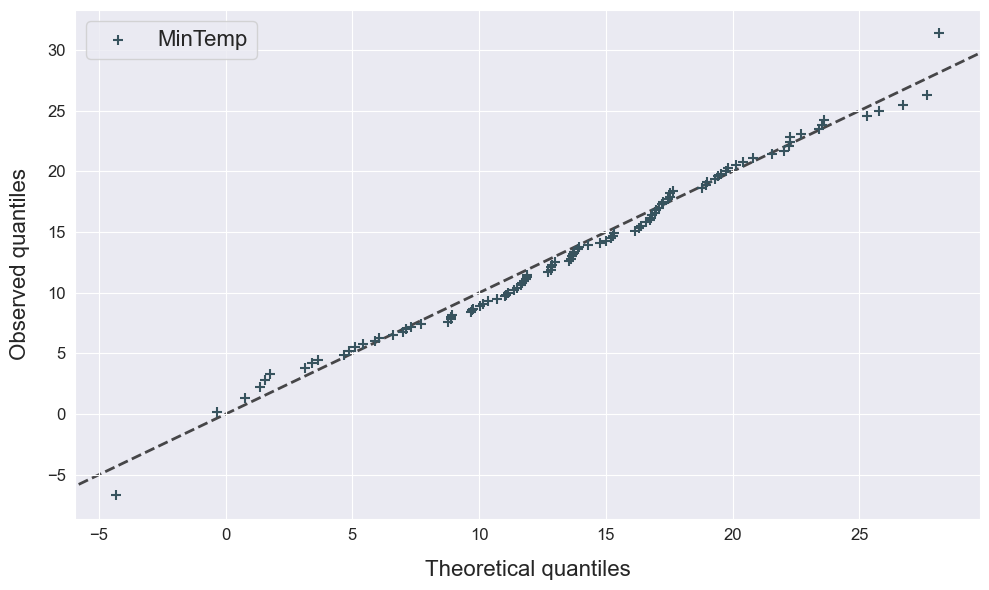

In [8]:
# Investigate a column's distribution
atom.plot_distribution(columns="MinTemp", distributions="beta")
atom.plot_qq(columns="MinTemp", distributions="beta")

## Change the data mid-pipeline

There are two ways to quickly transform the dataset mid-pipeline. The first way is through the property's `@setter`.
The downside for this approach is that the transformation is not stored in atom's pipeline, so the transformation is
not applied on new data. Therefore, we recommend using the second approach, through the add method.

In [9]:
# Note that we can only replace a dataframe with a new dataframe!
atom.X = atom.X.assign(AvgTemp=(atom.X["MaxTemp"] + atom.X["MinTemp"])/2)

# This will automatically update all other data attributes
assert "AvgTemp" in atom

# But it's not saved to atom's pipeline
atom.pipeline

0    Cleaner()
1    Imputer()
2    Encoder()
Name: master, dtype: object

In [10]:
# Same transformation, different approach (AvgTemp is overwritten)
atom.apply(lambda df: (df.MaxTemp + df.MinTemp)/2, columns="AvgTemp")

assert "AvgTemp" in atom

In [11]:
# Now the function appears in the pipeline
atom.pipeline

0                                          Cleaner()
1                                          Imputer()
2                                          Encoder()
3    FuncTransformer(func=<lambda>, columns=AvgTemp)
Name: master, dtype: object

## Get an overview of the available models

In [12]:
atom.available_models()

,acronym,fullname,estimator,module,needs_scaling,accepts_sparse,supports_gpu
0,Dummy,Dummy Estimator,DummyClassifier,sklearn.dummy,False,False,False
1,GP,Gaussian Process,GaussianProcessClassifier,sklearn.gaussian_process._gpc,False,False,False
2,GNB,Gaussian Naive Bayes,GaussianNB,sklearn.naive_bayes,False,False,True
3,MNB,Multinomial Naive Bayes,MultinomialNB,sklearn.naive_bayes,False,True,True
4,BNB,Bernoulli Naive Bayes,BernoulliNB,sklearn.naive_bayes,False,True,True
5,CatNB,Categorical Naive Bayes,CategoricalNB,sklearn.naive_bayes,False,True,True
6,CNB,Complement Naive Bayes,ComplementNB,sklearn.naive_bayes,False,True,False
7,Ridge,Ridge Estimator,RidgeClassifier,sklearn.linear_model._ridge,True,True,True
8,Perc,Perceptron,Perceptron,sklearn.linear_model._perceptron,True,False,False
9,LR,Logistic Regression,LogisticRegression,sklearn.linear_model._logistic,True,True,True


## Use a custom metric

In [13]:
atom.verbose = 1

# Define a custom metric
def f2(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# Use the greater_is_better, needs_proba and needs_threshold parameters if necessary
atom.run(models="LR", metric=f2)


Training ========================= >>
Models: LR
Metric: f2


Results for Logistic Regression:
Fit ---------------------------------------------
Train evaluation --> f2: 0.5685
Test evaluation --> f2: 0.5743
Time elapsed: 0.172s
-------------------------------------------------
Total time: 0.172s


Final results ==================== >>
Duration: 0.172s
-------------------------------------
Logistic Regression --> f2: 0.5743


## Customize the estimator's parameters

In [14]:
# You can use the est_params parameter to customize the estimator
# Let's run AdaBoost using LR instead of a decision tree as base estimator
atom.run("AdaB", est_params={"base_estimator": atom.lr.estimator})


Training ========================= >>
Models: AdaB
Metric: f2


Results for AdaBoost:
Fit ---------------------------------------------
Train evaluation --> f2: 0.5559
Test evaluation --> f2: 0.5642
Time elapsed: 2.016s
-------------------------------------------------
Total time: 2.016s


Final results ==================== >>
Duration: 2.016s
-------------------------------------
AdaBoost --> f2: 0.5642


In [15]:
atom.adab.estimator

AdaBoostClassifier(base_estimator=LogisticRegression(n_jobs=1, random_state=1),
                   random_state=1)

In [16]:
# Note that parameters specified by est_params are not optimized in the BO
atom.run(
    models="Tree",
    n_calls=10,
    n_initial_points=3,
    est_params={
        "criterion": "gini",
        "splitter": "best",
        "min_samples_leaf": 1,
        "ccp_alpha": 0.035,
    },
    verbose=2,
)


Training ========================= >>
Models: Tree
Metric: f2


Running BO for Decision Tree...
| call             | max_depth | min_samples_split | max_features |      f2 | best_f2 |    time | total_time |
| ---------------- | --------- | ----------------- | ------------ | ------- | ------- | ------- | ---------- |
| Initial point 1  |        16 |                19 |         sqrt |  0.4763 |  0.4763 |  1.893s |     1.909s |
| Initial point 2  |        16 |                 6 |          0.5 |  0.4882 |  0.4882 |  1.947s |     3.856s |
| Initial point 3  |         6 |                14 |          0.9 |  0.4751 |  0.4882 |  1.916s |     5.771s |
| Iteration 4      |        16 |                 3 |         sqrt |  0.5018 |  0.5018 |  1.837s |     7.812s |
| Iteration 5      |      None |                 2 |         None |  0.4919 |  0.5018 |  2.174s |    10.282s |
| Iteration 6      |        12 |                 2 |         auto |  0.4718 |  0.5018 |  1.814s |    12.281s |
| Iteration 7  

## Save & load

In [17]:
# Save the atom instance as a pickle
# Use save_data=False to save the instance without the data
atom.save("atom", save_data=False)

ATOMClassifier successfully saved.


In [18]:
# Load the instance again with ATOMLoader
# No need to store the transformed data, providing the original dataset to
# the loader automatically transforms it through all the steps in the pipeline
atom_2 = ATOMLoader("atom", data=(X,), verbose=2)

Transforming data for branch master:
Cleaning the data...
 --> Label-encoding the target column.
Imputing missing values...
 --> Dropping 637 samples due to missing values in feature MinTemp.
 --> Dropping 322 samples due to missing values in feature MaxTemp.
 --> Dropping 1406 samples due to missing values in feature Rainfall.
 --> Dropping 60843 samples due to missing values in feature Evaporation.
 --> Dropping 67816 samples due to missing values in feature Sunshine.
 --> Dropping 9330 samples due to missing values in feature WindGustDir.
 --> Dropping 9270 samples due to missing values in feature WindGustSpeed.
 --> Dropping 10013 samples due to missing values in feature WindDir9am.
 --> Dropping 3778 samples due to missing values in feature WindDir3pm.
 --> Dropping 1348 samples due to missing values in feature WindSpeed9am.
 --> Dropping 2630 samples due to missing values in feature WindSpeed3pm.
 --> Dropping 1774 samples due to missing values in feature Humidity9am.
 --> Droppi

## Customize the plot aesthetics

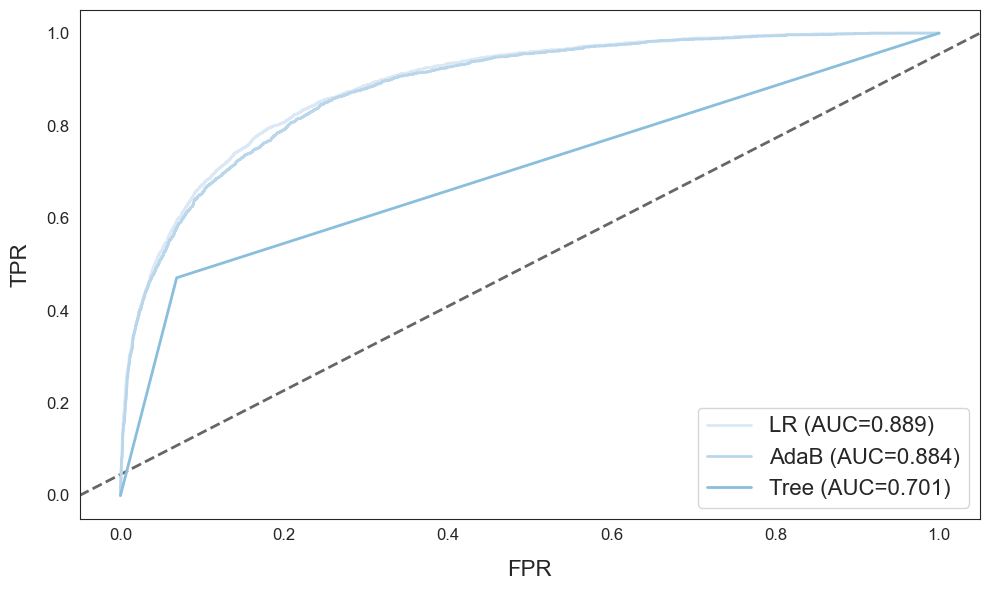

In [19]:
# Use the plotting attributes to further customize your plots!
atom_2.palette= "Blues"
atom_2.style = "white"

atom_2.plot_roc()

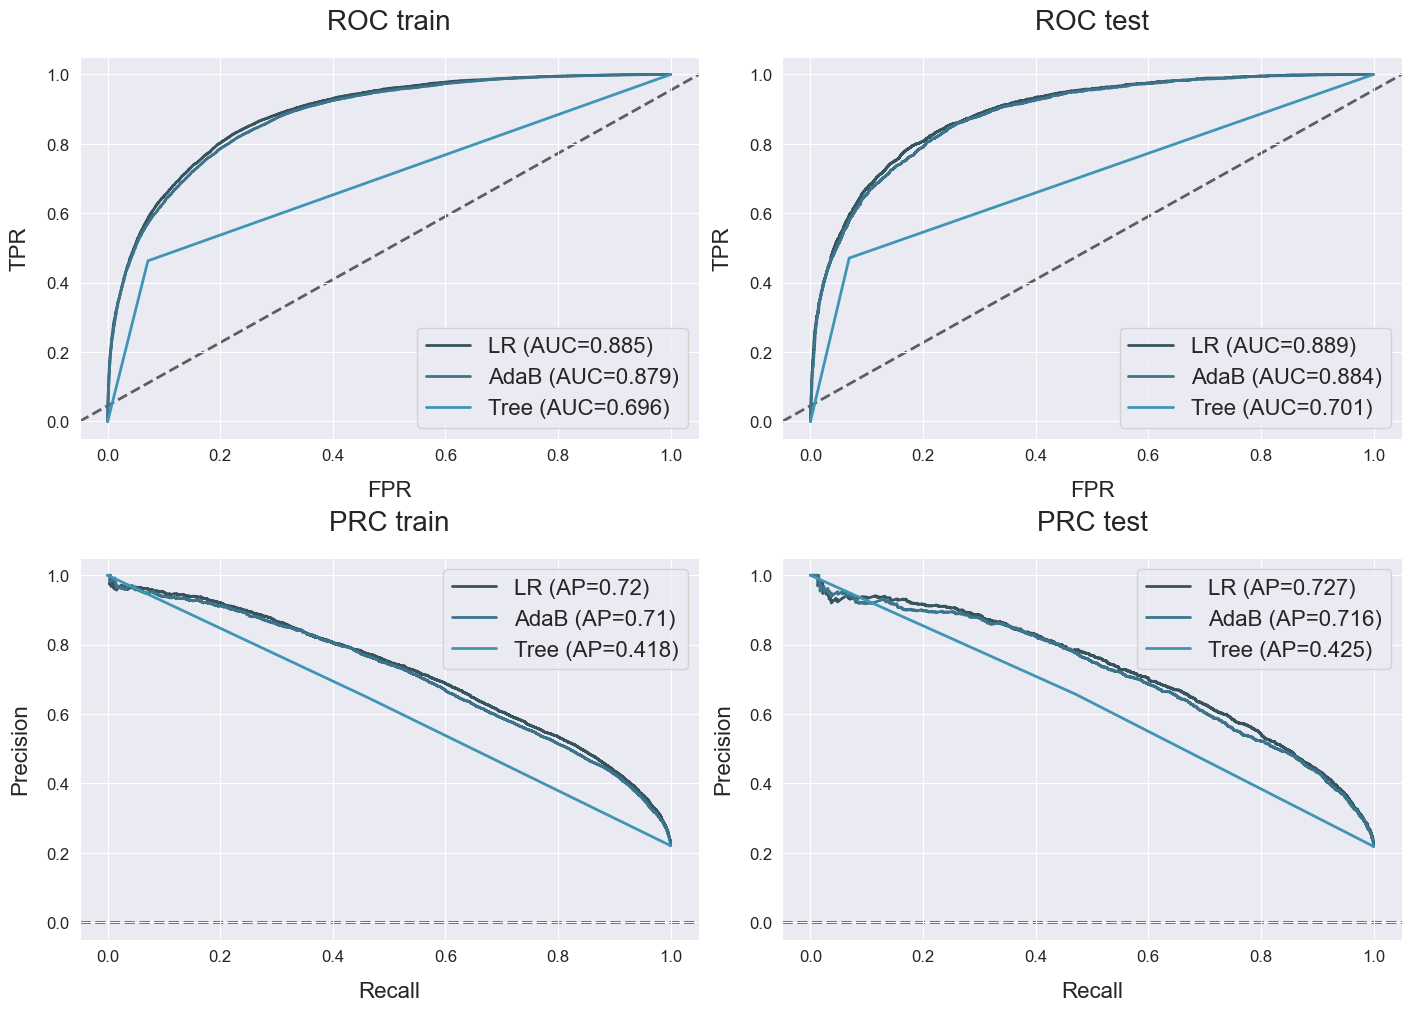

In [20]:
# Reset the aesthetics to their original values
atom_2.reset_aesthetics()

# Draw multiple plots in one figure using the canvas method
with atom.canvas(2, 2):
    atom_2.plot_roc(dataset="train", title="ROC train")
    atom_2.plot_roc(dataset="test", title="ROC test")
    atom_2.plot_prc(dataset="train", title="PRC train")
    atom_2.plot_prc(dataset="test", title="PRC test")

Note that both instances need to be initialized with the same data and use the same metric for model training to be able to merge.

In [21]:
# Create a separate instance with its own branch and model
atom_3 = ATOMClassifier(X, verbose=0, random_state=1)
atom_3.branch.rename("lightgbm")
atom_3.impute()
atom_3.encode()
atom_3.run("LGB", metric=f2)

In [22]:
# Merge the instances
atom_2.merge(atom_3)

Merging instances...
 --> Merging branch lightgbm.
 --> Merging model LGB.
 --> Merging attributes.


In [23]:
# Note that it now contains both branches and all models
atom_2

ATOMClassifier
 --> Branches:
   >>> master !
   >>> lightgbm
 --> Models: LR, AdaB, Tree, LGB
 --> Metric: f2
 --> Errors: 0

In [24]:
atom_2.results

,metric_bo,time_bo,metric_train,metric_test,time_fit,time
LR,NaN,None,0.568508,0.574347,0.172s,0.172s
AdaB,NaN,None,0.555887,0.564229,2.016s,2.016s
Tree,0.501835,19.001s,0.490803,0.499191,0.156s,19.157s
LGB,NaN,None,0.650216,0.601199,1.143s,1.143s
